Dataset

You will use the dataset provided in the following Kaggle project: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

The dataset contains:

· COVID-19 chest X-ray images

· Normal (no disease) chest X-ray images

· Viral Pneumonia chest X-ray images

1. Data Loading and Exploration

· Import necessary libraries (os, cv2, matplotlib, tensorflow, keras etc.)

· Import Covid19 dataset from Kaggle into colab using Kaggle API.

· Load images from different folders and label them

· Resize images to a fixed shape (e.g 128x128 or 224x224)

· Display a few sample images from each class

· Print dataset size per class

In [1]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [2]:
# pip install tensorflow

In [3]:
import kagglehub
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,classification_report, confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras import Sequential,layers,optimizers,Model,models
from keras.layers import Dense, Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Flatten,LeakyReLU , BatchNormalization,ReLU
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from keras.initializers import GlorotNormal
from keras_tuner import HyperModel, RandomSearch, BayesianOptimization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19,DenseNet121
from keras.optimizers import Adam
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC



pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format

In [4]:


# Download latest version (will be downloaded to /kaggle/input/...)
dataset_path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

# Define the desired destination path
destination_path = "/content/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the contents of the downloaded dataset to the destination path
# We use shell command for simplicity, you could also use shutil.copytree
!cp -r "{dataset_path}/." "{destination_path}/"

print(f"Dataset copied to: {destination_path}")

# List files in the destination directory to confirm
!ls "{destination_path}"

100%|██████████| 158M/158M [00:02<00:00, 73.1MB/s]

Extracting files...


Dataset copied to: /content/
Covid19-dataset  sample_data


In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

val_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Test set from separate 'test' folder
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Covid19-dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)


Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.
Found 66 files belonging to 3 classes.


In [6]:
class_names = train_ds.class_names
print("Class labels:", class_names)

class_names_test = test_ds.class_names
print("Class labels test:", class_names_test)

Class labels: ['Covid', 'Normal', 'Viral Pneumonia']
Class labels test: ['Covid', 'Normal', 'Viral Pneumonia']


Covid - 0

Normal - 1

Viral Pneumonia - 2

In [7]:
y_train_true = train_ds.class_names
y_test_true = test_ds.class_names
# class_names = list(train_ds.keys())

In [8]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)



Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [9]:
# count of images for each class for ttraining data
train_dir = '/content/Covid19-dataset/train'


for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            fname for fname in os.listdir(class_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        print(f"{class_name}: {count} images")


Covid: 111 images
Viral Pneumonia: 70 images
Normal: 70 images


2. Data Preprocessing

· Normalize pixel values (scale from 0–255 to 0–1)

· Encode class labels using one-hot encoding or LabelEncoder

· Split the data into training, validation and test sets (e.g 80-20%)

In [10]:
for images, _ in train_ds.take(1):
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())

## Currently image size is from 0 to 255

Min pixel value: 0.0
Max pixel value: 255.0


In [11]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

# # rescaling pixels from (0,255) to (0,1)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [12]:
## Confirming pixel rescaling
for images, _ in train_ds.take(1):
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())

Min pixel value: 0.0
Max pixel value: 255.0


In [13]:
## Lables are already labelled as 0, 1 & 2
## Validation split is considered while reading image files as 20% as validation dataset

3. Exploratory Data Analysis (EDA)

· Visualize class distribution using bar plots

· Plot sample images with their class names

· Observe patterns in data

Training data distribution: {'Covid': 111, 'Viral Pneumonia': 70, 'Normal': 70}
Test data distribution: {'Covid': 26, 'Viral Pneumonia': 20, 'Normal': 20}


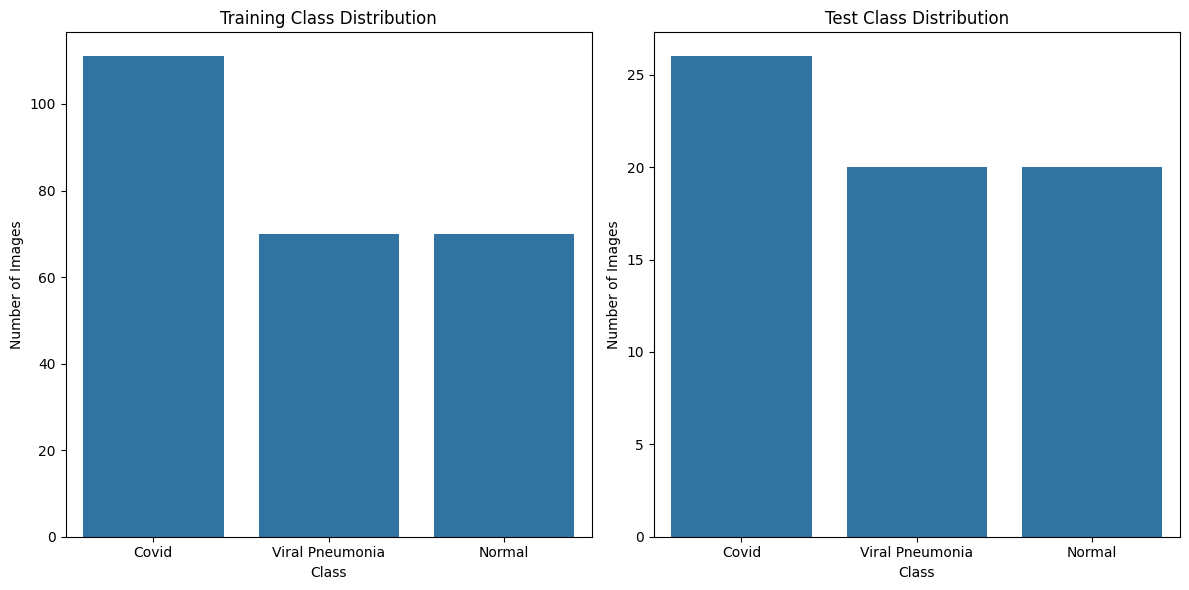

In [14]:
train_dir = '/content/Covid19-dataset/train'
test_dir = '/content/Covid19-dataset/test'

def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([
                fname for fname in os.listdir(class_path)
                if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            counts[class_name] = count
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training data distribution:", train_counts)
print("Test data distribution:", test_counts)

# Plotting class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=axes[0])
axes[0].set_title('Training Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=axes[1])
axes[1].set_title('Test Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [15]:
# count of images for each class for test data
train_dir = '/content/Covid19-dataset/test'


for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            fname for fname in os.listdir(class_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        print(f"{class_name}: {count} images")


Covid: 26 images
Viral Pneumonia: 20 images
Normal: 20 images


In [16]:
# count of images for each class for test data
train_dir = '/content/Covid19-dataset/train'


for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            fname for fname in os.listdir(class_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        print(f"{class_name}: {count} images")


Covid: 111 images
Viral Pneumonia: 70 images
Normal: 70 images


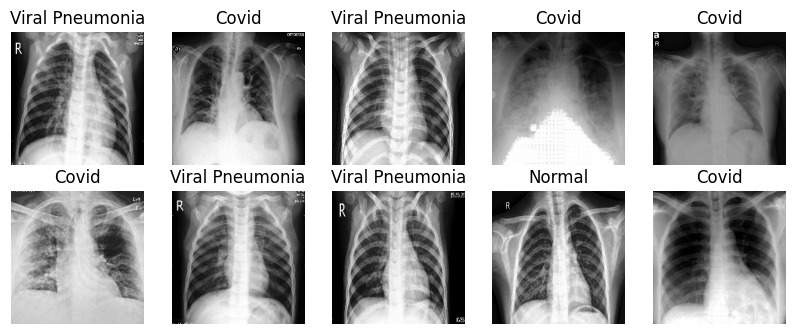

In [17]:
class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow((images[i].numpy().astype("uint8")))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


Observation

Looking all the above images using after normalizing pixels to (0,1) to (0,255) and then converting to uint8 making more sense as it captures the details.

4. CNN Model Building

Create and train multiple CNN architectures:

· Model 1: Basic CNN

o Conv2D -> MaxPooling -> Flatten -> Dense

· Model 2: Transfer Learning

o Use pre-trained models like VGG16, ResNet50 etc

o Fine-tune last few layers on the COVID dataset

· Model 3: Transfer Learning + Data Augmentation

o Do the data Augmentation using ImageDataGenerator.

o The use the pretrained models to get the prediction.

In [18]:
early_stop = EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True)

In [19]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    layers.Conv2D(512, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128),
    layers.LeakyReLU(alpha=0.1),
    layers.Dense(3, activation='softmax')  # Assuming 3 classes
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [20]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 112, 112, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,307,715 (20.25 MB)

 Trainable params: 5,307,715 (20.25 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(train_ds,epochs=80,validation_data=val_ds,callbacks=[early_stop])

Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.4198 - loss: 4.3784 - val_accuracy: 0.2400 - val_loss: 1.5539
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2457 - loss: 1.2667 - val_accuracy: 0.4800 - val_loss: 0.9949
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5162 - loss: 1.0048 - val_accuracy: 0.7000 - val_loss: 0.7583
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7578 - loss: 0.6925 - val_accuracy: 0.7800 - val_loss: 0.5951
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7507 - loss: 0.5596 - val_accuracy: 0.8800 - val_loss: 0.4271
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8791 - loss: 0.3170 - val_accuracy: 0.8000 - val_loss: 0.5727
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8425 - loss: 0.3833 - val_accuracy: 0.9000 - val_loss: 0.3572
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9299 - loss: 0.1953 - val_accuracy: 0.8800 - val_loss: 0.3920
Epoch 9/80


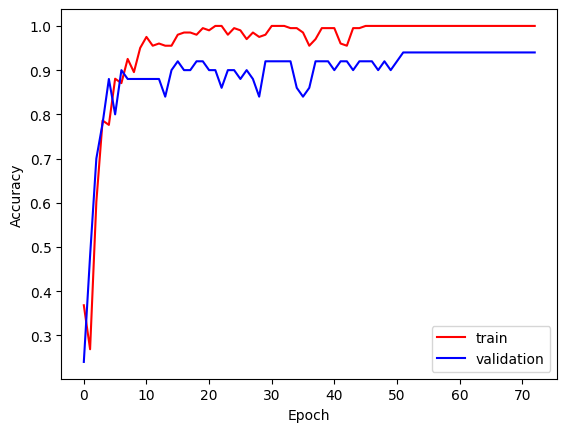

In [23]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

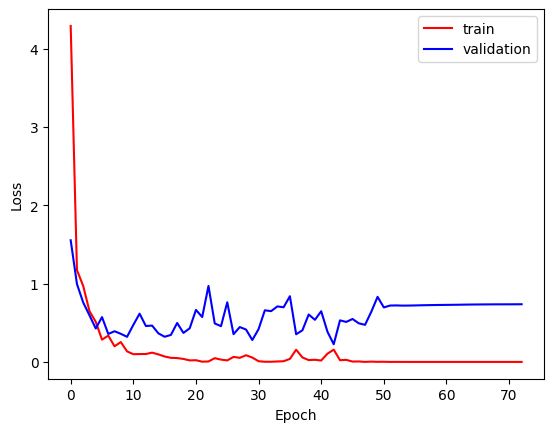

In [24]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
y_true = np.concatenate([y for x, y in train_ds], axis=0)

y_pred_probs = model.predict(train_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


print("Accuracy:", accuracy_score(y_true, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print("Classification Report:\n", classification_report(y_true, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 552ms/step
Accuracy: 0.3283582089552239
Confusion Matrix:
 [[35 24 28]
 [27 17 14]
 [25 17 14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40        87
           1       0.29      0.29      0.29        58
           2       0.25      0.25      0.25        56

    accuracy                           0.33       201
   macro avg       0.32      0.32      0.32       201
weighted avg       0.33      0.33      0.33       201



In [26]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


print("Accuracy:", accuracy_score(y_true, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print("Classification Report:\n", classification_report(y_true, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Accuracy: 0.9242424242424242
Confusion Matrix:
 [[26  0  0]
 [ 0 19  1]
 [ 3  1 16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        26
           1       0.95      0.95      0.95        20
           2       0.94      0.80      0.86        20

    accuracy                           0.92        66
   macro avg       0.93      0.92      0.92        66
weighted avg       0.93      0.92      0.92        66



In [27]:
model_summaries = []
model_conf_matrices = {}
model_class_reports = {}

def get_labels_from_dataset(dataset):
    labels = []
    for batch in dataset:
        _, batch_labels = batch
        labels.extend(batch_labels.numpy())
    return np.array(labels)

def get_predictions(model, dataset):
    predictions = model.predict(dataset)
    return np.argmax(predictions, axis=1)


def evaluate_model_full(model, train_ds, test_ds, model_name, params=None):
    # Get true labels
    y_train_true = get_labels_from_dataset(train_ds)
    y_test_true = get_labels_from_dataset(test_ds)

    # Get predictions
    y_train_pred = get_predictions(model, train_ds)
    y_test_pred = get_predictions(model, test_ds)

    # Class names
    class_names = train_ds.class_names

    # Accuracy and loss
    train_loss, train_acc = model.evaluate(train_ds, verbose=0)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    # Confusion matrices
    train_cm = pd.DataFrame(confusion_matrix(y_train_true, y_train_pred), index=class_names, columns=class_names)
    test_cm = pd.DataFrame(confusion_matrix(y_test_true, y_test_pred), index=class_names, columns=class_names)

    # Classification reports
    train_report_dict = classification_report(y_train_true, y_train_pred, target_names=class_names, output_dict=True)
    test_report_dict = classification_report(y_test_true, y_test_pred, target_names=class_names, output_dict=True)

    train_report = pd.DataFrame(train_report_dict).transpose()
    test_report = pd.DataFrame(test_report_dict).transpose()

    # Extract macro-averaged precision and recall
    train_precision = train_report_dict['macro avg']['precision']
    train_recall = train_report_dict['macro avg']['recall']
    test_precision = test_report_dict['macro avg']['precision']
    test_recall = test_report_dict['macro avg']['recall']

    # Summary row
    summary_row = {
        'Model': model_name,
        'Parameters': params,
        'Train Accuracy': train_acc,
        'Train Loss': train_loss,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Test Accuracy': test_acc,
        'Test Loss': test_loss,
        'Test Precision': test_precision,
        'Test Recall': test_recall
    }

    # Store results
    model_summaries.append(summary_row)
    model_conf_matrices[model_name] = {'train': train_cm, 'test': test_cm}
    model_class_reports[model_name] = {'train': train_report, 'test': test_report}


In [28]:




# def evaluate_model_full(model, train_ds, test_ds, model_name, params=None):
#     # Disable shuffling to preserve order


#     # Get true labels
#     y_train_true = get_labels_from_dataset(train_ds)
#     y_test_true = get_labels_from_dataset(test_ds)

#     # Get predictions
#     y_train_pred = get_predictions(model, train_ds)
#     y_test_pred = get_predictions(model, test_ds)

#     # Class names
#     class_names = train_ds.class_names

#     # Accuracy and loss
#     train_loss, train_acc = model.evaluate(train_ds, verbose=0)
#     test_loss, test_acc = model.evaluate(test_ds, verbose=0)

#     # Confusion matrices
#     train_cm = pd.DataFrame(confusion_matrix(y_train_true, y_train_pred), index=class_names, columns=class_names)
#     test_cm = pd.DataFrame(confusion_matrix(y_test_true, y_test_pred), index=class_names, columns=class_names)

#     # Classification reports
#     train_report = pd.DataFrame(classification_report(y_train_true, y_train_pred, target_names=class_names, output_dict=True)).transpose()
#     test_report = pd.DataFrame(classification_report(y_test_true, y_test_pred, target_names=class_names, output_dict=True)).transpose()

#     # Summary row
#     summary_row = {
#         'Model': model_name,
#         'Parameters': params,
#         'Train Accuracy': train_acc,
#         'Train Loss': train_loss,
#         'Test Accuracy': test_acc,
#         'Test Loss': test_loss
#     }

#     # Store results
#     model_summaries.append(summary_row)
#     model_conf_matrices[model_name] = {'train': train_cm, 'test': test_cm}
#     model_class_reports[model_name] = {'train': train_report, 'test': test_report}


In [29]:
evaluate_model_full(model, train_ds, test_ds, "Model1: Basic CNN", params="Conv2D stack, LeakyReLU")
summary_df = pd.DataFrame(model_summaries)
summary_df


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 491ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


,Model,Parameters,Train Accuracy,Train Loss,Train Precision,Train Recall,Test Accuracy,Test Loss,Test Precision,Test Recall
0,Model1: Basic CNN,"Conv2D stack, LeakyReLU",1.0000,0.0473,0.3111,0.3111,0.9242,0.2532,0.9292,0.9167


· Model 2: Transfer Learning

In [30]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
base_model.trainable = False

In [32]:
model_transfer = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax') ])

In [33]:
model_transfer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
history_transfer = model_transfer.fit(train_ds, epochs=100, validation_data=val_ds,callbacks=[early_stop])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.4941 - loss: 39.4131 - val_accuracy: 0.8800 - val_loss: 5.0262
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 433ms/step - accuracy: 0.8648 - loss: 7.0931 - val_accuracy: 0.8400 - val_loss: 6.5429
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.8656 - loss: 4.7114 - val_accuracy: 0.9400 - val_loss: 0.9875
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.9469 - loss: 2.1401 - val_accuracy: 0.9200 - val_loss: 1.7429
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.9752 - loss: 0.8529 - val_accuracy: 0.9000 - val_loss: 4.2248
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.9674 - loss: 1.4839 - val_accuracy: 0.9600 - val_loss: 0.7698
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.9870 - loss: 0.2472 - val_accuracy: 0.9600 - val_loss: 1.0009
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.9888 - loss: 0.1165 - val_accuracy: 0.9000 - v

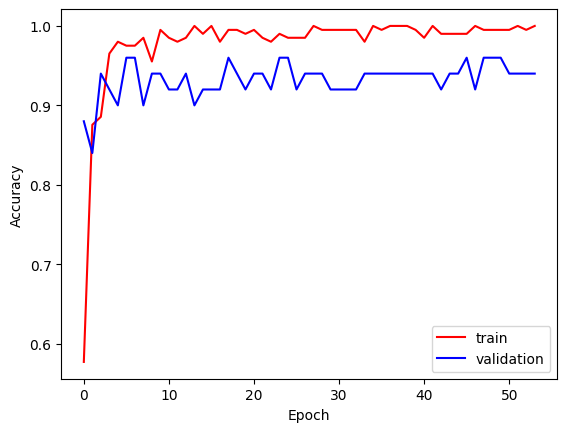

In [35]:
plt.plot(history_transfer.history['accuracy'],color='red',label='train')
plt.plot(history_transfer.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

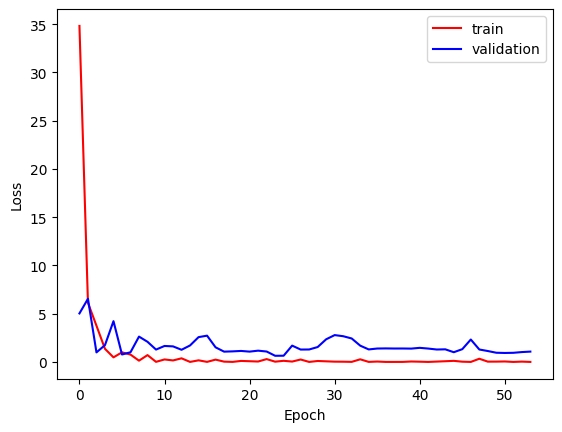

In [36]:
plt.plot(history_transfer.history['loss'],color='red',label='train')
plt.plot(history_transfer.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
y_true = np.concatenate([y for x, y in train_ds], axis=0)

y_pred_probs = model_transfer.predict(train_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


print("Accuracy:", accuracy_score(y_true, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print("Classification Report:\n", classification_report(y_true, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step
Accuracy: 0.4129353233830846
Confusion Matrix:
 [[41 22 24]
 [24 22 12]
 [22 14 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.47      0.47        87
           1       0.38      0.38      0.38        58
           2       0.36      0.36      0.36        56

    accuracy                           0.41       201
   macro avg       0.40      0.40      0.40       201
weighted avg       0.41      0.41      0.41       201



In [38]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

y_pred_probs = model_transfer.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


print("Accuracy:", accuracy_score(y_true, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print("Classification Report:\n", classification_report(y_true, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Accuracy: 0.9696969696969697
Confusion Matrix:
 [[25  1  0]
 [ 0 19  1]
 [ 0  0 20]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.95      0.95      0.95        20
           2       0.95      1.00      0.98        20

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66



In [39]:
evaluate_model_full(model_transfer, train_ds, test_ds, "VGG19", params="VGG19, ReLU")
summary_df = pd.DataFrame(model_summaries)
summary_df


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


,Model,Parameters,Train Accuracy,Train Loss,Train Precision,Train Recall,Test Accuracy,Test Loss,Test Precision,Test Recall
0,Model1: Basic CNN,"Conv2D stack, LeakyReLU",1.0000,0.0473,0.3111,0.3111,0.9242,0.2532,0.9292,0.9167
1,VGG19,"VGG19, ReLU",1.0000,0.0000,0.3285,0.3285,0.9697,0.3604,0.9675,0.9705


In [ ]:
model_transfer

o Fine-tune last few layers on the COVID dataset

In [40]:
base_model.trainable = True

# Freeze first few layers
for layer in base_model.layers[:10]:
    layer.trainable = False

model_transfer_tuning = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax') ])


model_transfer_tuning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history_finetune = model_transfer_tuning.fit(train_ds,epochs=100,validation_data=val_ds,callbacks=[early_stop])





Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.3662 - loss: 10.0498 - val_accuracy: 0.4000 - val_loss: 2.0875
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 713ms/step - accuracy: 0.3933 - loss: 4.3769 - val_accuracy: 0.5600 - val_loss: 1.3747
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 617ms/step - accuracy: 0.4629 - loss: 2.8191 - val_accuracy: 0.6400 - val_loss: 0.9186
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step - accuracy: 0.4319 - loss: 2.3366 - val_accuracy: 0.6800 - val_loss: 0.8367
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 600ms/step - accuracy: 0.5542 - loss: 1.5463 - val_accuracy: 0.7200 - val_loss: 0.7831
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 563ms/step - accuracy: 0.4365 - loss: 1.7459 - val_accuracy: 0.8000 - val_loss: 0.6910
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - accuracy: 0.5030 - loss: 1.4152 - val_accuracy: 0.8000 - val_loss: 0.6276
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.5128 - loss: 1.1141 - val_accuracy: 0.8200 - v

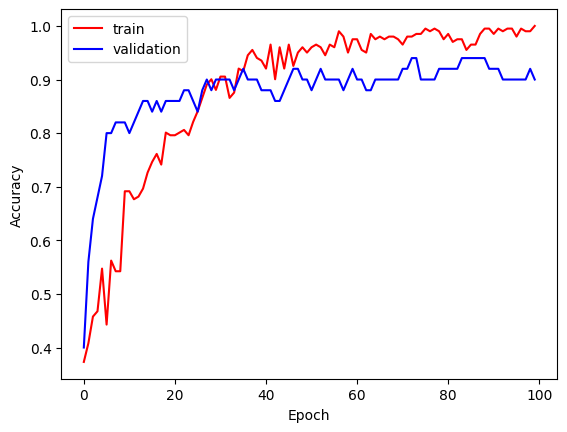

In [41]:
plt.plot(history_finetune.history['accuracy'],color='red',label='train')
plt.plot(history_finetune.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

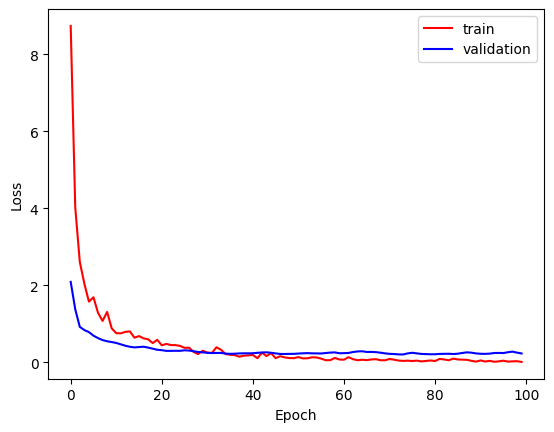

In [42]:
plt.plot(history_finetune.history['loss'],color='red',label='train')
plt.plot(history_finetune.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
y_true = np.concatenate([y for x, y in train_ds], axis=0)

y_pred_probs = model_transfer_tuning.predict(train_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


print("Accuracy:", accuracy_score(y_true, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print("Classification Report:\n", classification_report(y_true, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step
Accuracy: 0.26865671641791045
Confusion Matrix:
 [[29 29 29]
 [28 14 16]
 [30 15 11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.33      0.33        87
           1       0.24      0.24      0.24        58
           2       0.20      0.20      0.20        56

    accuracy                           0.27       201
   macro avg       0.26      0.26      0.26       201
weighted avg       0.27      0.27      0.27       201



In [44]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

y_pred_probs = model_transfer_tuning.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


print("Accuracy:", accuracy_score(y_true, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print("Classification Report:\n", classification_report(y_true, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
Accuracy: 0.9393939393939394
Confusion Matrix:
 [[26  0  0]
 [ 0 19  1]
 [ 0  3 17]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.86      0.95      0.90        20
           2       0.94      0.85      0.89        20

    accuracy                           0.94        66
   macro avg       0.94      0.93      0.93        66
weighted avg       0.94      0.94      0.94        66



In [45]:
evaluate_model_full(model_transfer_tuning, train_ds, test_ds, "VGG19 - Fine Tuning", params="VGG19,ReLU,Dropout")
summary_df = pd.DataFrame(model_summaries)
summary_df

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


,Model,Parameters,Train Accuracy,Train Loss,Train Precision,Train Recall,Test Accuracy,Test Loss,Test Precision,Test Recall
0,Model1: Basic CNN,"Conv2D stack, LeakyReLU",1.0000,0.0473,0.3111,0.3111,0.9242,0.2532,0.9292,0.9167
1,VGG19,"VGG19, ReLU",1.0000,0.0000,0.3285,0.3285,0.9697,0.3604,0.9675,0.9705
2,VGG19 - Fine Tuning,"VGG19,ReLU,Dropout",1.0000,0.0019,0.3758,0.3758,0.9394,0.2041,0.9360,0.9333


· Model 3: Transfer Learning + Data Augmentation

o Do the data Augmentation using ImageDataGenerator.

o The use the pretrained models to get the prediction.

Covid: 111 images
Viral Pneumonia: 70 images
Normal: 70 images


/tmp/ipython-input-211913470.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette='viridis')


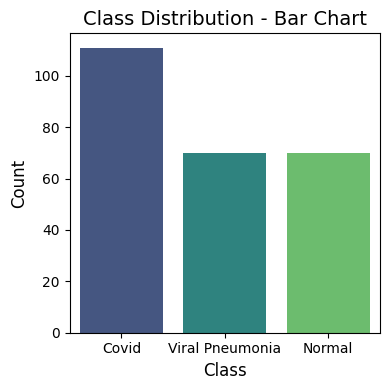

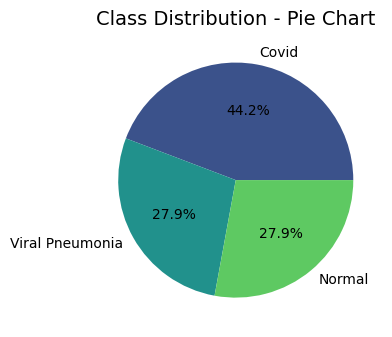

In [46]:
### Checking for the class imbalance
train_dir = '/content/Covid19-dataset/train'
class_counts_dict = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            fname for fname in os.listdir(class_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        class_counts_dict[class_name] = count
        print(f"{class_name}: {count} images")

# Convert to DataFrame
df = pd.DataFrame(list(class_counts_dict.items()), columns=['Class', 'Count'])

# Bar chart
plt.figure(figsize=(4, 4))
sns.barplot(x='Class', y='Count', data=df, palette='viridis')
plt.title('Class Distribution - Bar Chart', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

plt.show()

# Pie chart
plt.figure(figsize=(4, 4))
plt.pie(df['Count'], labels=df['Class'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(df)))
plt.title('Class Distribution - Pie Chart', fontsize=14)
plt.tight_layout()

plt.show()




In [47]:
# Augmentation settings
augmentor = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    # width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

# Paths to minority class directories
train_dir = 'Covid19-dataset/train'
minority_classes = ['Viral Pneumonia', 'Normal']

for class_name in minority_classes:
    class_path = os.path.join(train_dir, class_name)
    image_files = [
        fname for fname in os.listdir(class_path)
        if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    for fname in image_files:
        img_path = os.path.join(class_path, fname)
        img = tf.keras.preprocessing.image.load_img(img_path)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate 30 augmented images per original
        i = 0
        for batch in augmentor.flow(x, batch_size=1, save_to_dir=class_path,
                                    save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= 1:
                break


In [48]:
train_generator = keras.utils.image_dataset_from_directory(
    directory='/content/Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

val_generator = keras.utils.image_dataset_from_directory(
    directory='/content/Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Test set from separate 'test' folder
test_generator = keras.utils.image_dataset_from_directory(
    directory='/content/Covid19-dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)


Found 391 files belonging to 3 classes.
Using 313 files for training.
Found 391 files belonging to 3 classes.
Using 78 files for validation.
Found 66 files belonging to 3 classes.


In [49]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.1,
#     # height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     # horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator(rescale=1./255)

# test_datagen = ImageDataGenerator(rescale=1./255)

In [50]:
# train_generator = train_datagen.flow_from_directory(
#     directory='/content/Covid19-dataset/train',
#     batch_size=32,
#     target_size=(224, 224),
#     shuffle=True,
#     class_mode='categorical',
#     seed=123
# )

# val_generator = val_datagen.flow_from_directory(
#     directory='/content/Covid19-dataset/train',
#     batch_size=32,
#     target_size=(224, 224),
#     shuffle=True,
#     class_mode='categorical',
#     seed=123
# )

# test_generator = test_datagen.flow_from_directory(
#     directory='/content/Covid19-dataset/test',
#     batch_size=32,
#     target_size=(224, 224),
#     class_mode='categorical',
#     shuffle=False
# )


Covid: 111 images
Viral Pneumonia: 140 images
Normal: 140 images


/tmp/ipython-input-3539652508.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette='viridis')


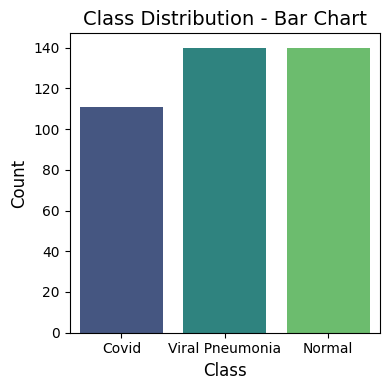

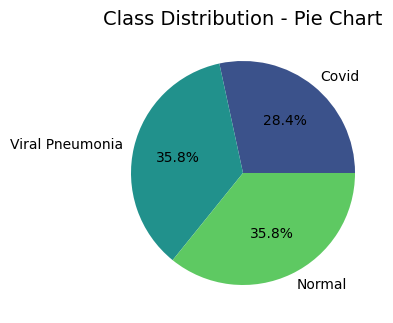

In [51]:
### Verifying again for the class imbalance
train_dir = '/content/Covid19-dataset/train'
class_counts_dict = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            fname for fname in os.listdir(class_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        class_counts_dict[class_name] = count
        print(f"{class_name}: {count} images")

# Convert to DataFrame
df = pd.DataFrame(list(class_counts_dict.items()), columns=['Class', 'Count'])

# Bar chart
plt.figure(figsize=(4, 4))
sns.barplot(x='Class', y='Count', data=df, palette='viridis')
plt.title('Class Distribution - Bar Chart', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

plt.show()

# Pie chart
plt.figure(figsize=(4, 4))
plt.pie(df['Count'], labels=df['Class'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(df)))
plt.title('Class Distribution - Pie Chart', fontsize=14)
plt.tight_layout()

plt.show()




In [52]:
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model



In [53]:
model_densenet_augumentation = Sequential([
    base_model,
    Dropout(0.7),
    GlobalAveragePooling2D(),
    Dropout(0.7),
    Dense(3, activation='softmax',
          kernel_initializer=GlorotNormal(),
          kernel_regularizer=L2(0.0001),
          bias_regularizer=L2(0.0001))
])

# Freeze first 200 layers
for layer in model_densenet_augumentation.layers[0].layers[:200]:
    layer.trainable = False
for layer in model_densenet_augumentation.layers[0].layers[200:]:
    layer.trainable = True

In [54]:


model_densenet_augumentation.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
          , loss = 'sparse_categorical_crossentropy', metrics =  ['accuracy'])

In [55]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True)

In [56]:
history = model_densenet_augumentation.fit(train_generator,validation_data=val_generator,batch_size = 32,
    epochs = 50,
    callbacks = [reduce_lr, early_stop])


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 223s 13s/step - accuracy: 0.3537 - loss: 1.4710 - val_accuracy: 0.3077 - val_loss: 4.6899 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 580ms/step - accuracy: 0.6502 - loss: 0.7966 - val_accuracy: 0.3077 - val_loss: 3.1117 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - accuracy: 0.7800 - loss: 0.5313 - val_accuracy: 0.3205 - val_loss: 2.8200 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - accuracy: 0.8178 - loss: 0.4464 - val_accuracy: 0.3590 - val_loss: 2.6812 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - accuracy: 0.8496 - loss: 0.3549 - val_accuracy: 0.3205 - val_loss: 2.5445 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.8730 - loss: 0.3086 - val_accuracy: 0.3205 - val_loss: 2.4452 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 526ms/step - accuracy

In [57]:
evaluate_model_full(model_densenet_augumentation, train_generator, test_generator, "DenseNet - Image augumentation", params="DenseNet,GlorotNormal")
summary_df = pd.DataFrame(model_summaries)
summary_df

10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step


,Model,Parameters,Train Accuracy,Train Loss,Train Precision,Train Recall,Test Accuracy,Test Loss,Test Precision,Test Recall
0,Model1: Basic CNN,"Conv2D stack, LeakyReLU",1.0000,0.0473,0.3111,0.3111,0.9242,0.2532,0.9292,0.9167
1,VGG19,"VGG19, ReLU",1.0000,0.0000,0.3285,0.3285,0.9697,0.3604,0.9675,0.9705
2,VGG19 - Fine Tuning,"VGG19,ReLU,Dropout",1.0000,0.0019,0.3758,0.3758,0.9394,0.2041,0.9360,0.9333
3,DenseNet - Image augumentation,"DenseNet,GlorotNormal",1.0000,0.0028,0.3539,0.3539,0.9545,0.1479,0.9516,0.9538


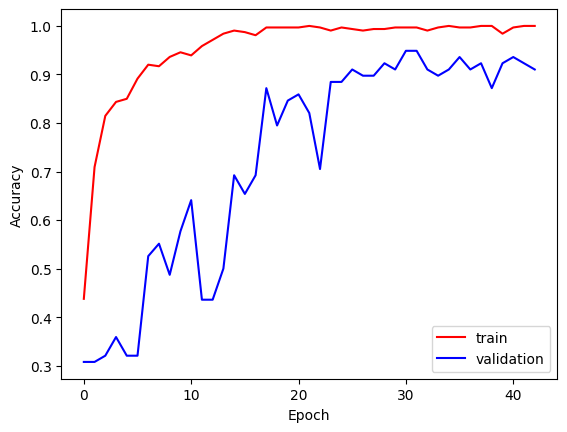

In [58]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

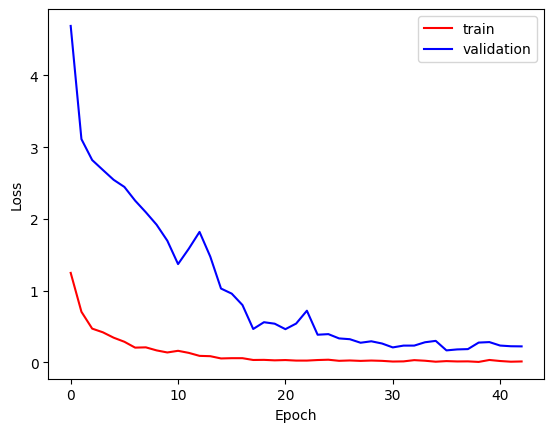

In [59]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
y_true = test_generator.class_names

y_pred_probs = model_densenet_augumentation.predict(test_generator)

y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Classification Report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


ValueError: Found input variables with inconsistent numbers of samples: [3, 66]

In [ ]:
y_true = train_generator.classes

y_pred_probs = model_densenet_augumentation.predict(train_generator, steps=train_generator.samples // train_generator.batch_size + 1)

y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Classification Report
class_names = list(train_generator.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


In [63]:
# with batch Normalization

model_densenet_augumentation_batch = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')
])


In [64]:
model_densenet_augumentation_batch.compile(optimizer=Adam(0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [65]:
history_batch = model_densenet_augumentation_batch.fit(train_generator,epochs=120,validation_data=val_generator,callbacks=[early_stop])


Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 193s 10s/step - accuracy: 0.6149 - loss: 1.0494 - val_accuracy: 0.8077 - val_loss: 0.6155
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 607ms/step - accuracy: 0.9656 - loss: 0.1260 - val_accuracy: 0.7949 - val_loss: 0.5744
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - accuracy: 0.9966 - loss: 0.0333 - val_accuracy: 0.8590 - val_loss: 0.3466
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 630ms/step - accuracy: 0.9994 - loss: 0.0224 - val_accuracy: 0.8718 - val_loss: 0.2918
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - accuracy: 0.9967 - loss: 0.0150 - val_accuracy: 0.8846 - val_loss: 0.3163
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 447ms/step - accuracy: 0.9891 - loss: 0.0538 - val_accuracy: 0.8462 - val_loss: 0.3826
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 0.9668 - loss: 0.0694 - val_accuracy: 0.8974 - val_loss: 0.3532
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 520ms/step - accuracy: 0.9828 - loss: 0.0394 - val_acc

In [66]:
evaluate_model_full(model_densenet_augumentation_batch, train_generator, test_generator, "DenseNet-Image augumentation",
                    params="DenseNet,ReLU,batchNormalization")
summary_df = pd.DataFrame(model_summaries)
summary_df

10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


,Model,Parameters,Train Accuracy,Train Loss,Train Precision,Train Recall,Test Accuracy,Test Loss,Test Precision,Test Recall
0,Model1: Basic CNN,"Conv2D stack, LeakyReLU",1.0000,0.0473,0.3111,0.3111,0.9242,0.2532,0.9292,0.9167
1,VGG19,"VGG19, ReLU",1.0000,0.0000,0.3285,0.3285,0.9697,0.3604,0.9675,0.9705
2,VGG19 - Fine Tuning,"VGG19,ReLU,Dropout",1.0000,0.0019,0.3758,0.3758,0.9394,0.2041,0.9360,0.9333
3,DenseNet - Image augumentation,"DenseNet,GlorotNormal",1.0000,0.0028,0.3539,0.3539,0.9545,0.1479,0.9516,0.9538
4,DenseNet-Image augumentation,"DenseNet,ReLU,batchNormalization",1.0000,0.0089,0.3316,0.3316,0.8636,0.2947,0.8825,0.8615


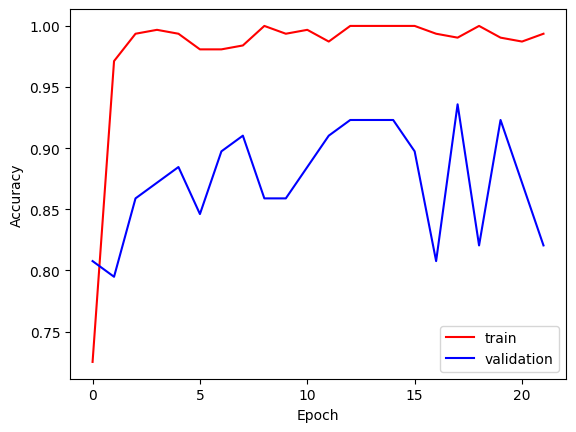

In [67]:
plt.plot(history_batch.history['accuracy'],color='red',label='train')
plt.plot(history_batch.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

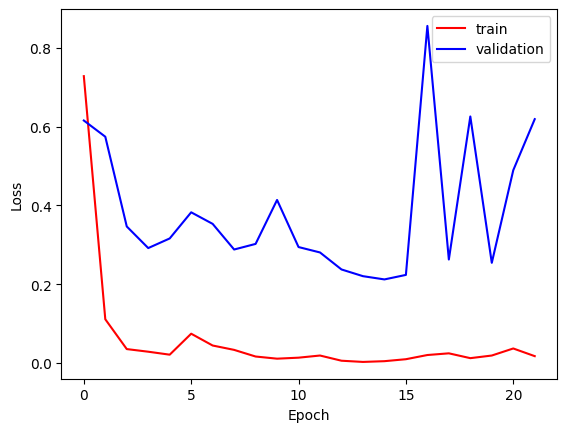

In [68]:
plt.plot(history_batch.history['loss'],color='red',label='train')
plt.plot(history_batch.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_true = test_generator.classes

y_pred_probs = model_densenet_augumentation_batch.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Classification Report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
y_true = train_generator.classes

y_pred_probs = model_densenet_augumentation_batch.predict(train_generator, steps=train_generator.samples // train_generator.batch_size + 1)

y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Classification Report
class_names = list(train_generator.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


With BatchNormalization and adding seperate layer for Relu

In [69]:
# with batch Normalization

model_densenet_relu_batch = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),

    Dense(512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),

    Dense(3, activation='softmax')
])


In [70]:
model_densenet_relu_batch.compile(optimizer=Adam(0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_batch_relu = model_densenet_relu_batch.fit(train_generator,epochs=120,validation_data=val_generator,callbacks=[early_stop])


Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - accuracy: 0.5278 - loss: 1.0752 - val_accuracy: 0.6154 - val_loss: 0.7820
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 499ms/step - accuracy: 0.9376 - loss: 0.2272 - val_accuracy: 0.7692 - val_loss: 0.6395
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 579ms/step - accuracy: 0.9816 - loss: 0.1145 - val_accuracy: 0.7949 - val_loss: 0.5177
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.9983 - loss: 0.0496 - val_accuracy: 0.8462 - val_loss: 0.4245
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - accuracy: 1.0000 - loss: 0.0441 - val_accuracy: 0.8846 - val_loss: 0.3319
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 526ms/step - accuracy: 1.0000 - loss: 0.0310 - val_accuracy: 0.9103 - val_loss: 0.2675
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 545ms/step - accuracy: 0.9979 - loss: 0.0250 - val_accuracy: 0.9103 - val_loss: 0.2554
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.9945 - loss: 0.0354 - val_a

In [71]:
evaluate_model_full(model_densenet_relu_batch, train_generator, test_generator, "DenseNet-Image augumentation",
                    params="DenseNet,ReLU,batchNormalization,Dropout")
summary_df = pd.DataFrame(model_summaries)
summary_df

10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


,Model,Parameters,Train Accuracy,Train Loss,Train Precision,Train Recall,Test Accuracy,Test Loss,Test Precision,Test Recall
0,Model1: Basic CNN,"Conv2D stack, LeakyReLU",1.0000,0.0473,0.3111,0.3111,0.9242,0.2532,0.9292,0.9167
1,VGG19,"VGG19, ReLU",1.0000,0.0000,0.3285,0.3285,0.9697,0.3604,0.9675,0.9705
2,VGG19 - Fine Tuning,"VGG19,ReLU,Dropout",1.0000,0.0019,0.3758,0.3758,0.9394,0.2041,0.9360,0.9333
3,DenseNet - Image augumentation,"DenseNet,GlorotNormal",1.0000,0.0028,0.3539,0.3539,0.9545,0.1479,0.9516,0.9538
4,DenseNet-Image augumentation,"DenseNet,ReLU,batchNormalization",1.0000,0.0089,0.3316,0.3316,0.8636,0.2947,0.8825,0.8615
5,DenseNet-Image augumentation,"DenseNet,ReLU,batchNormalization,Dropout",1.0000,0.0193,0.3101,0.3101,0.9091,0.2448,0.9231,0.9038


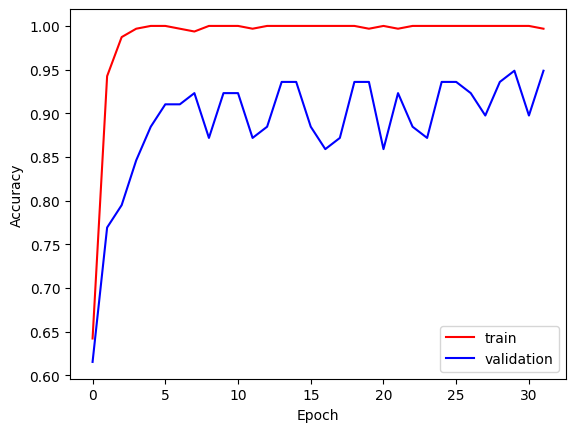

In [72]:
plt.plot(history_batch_relu.history['accuracy'],color='red',label='train')
plt.plot(history_batch_relu.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

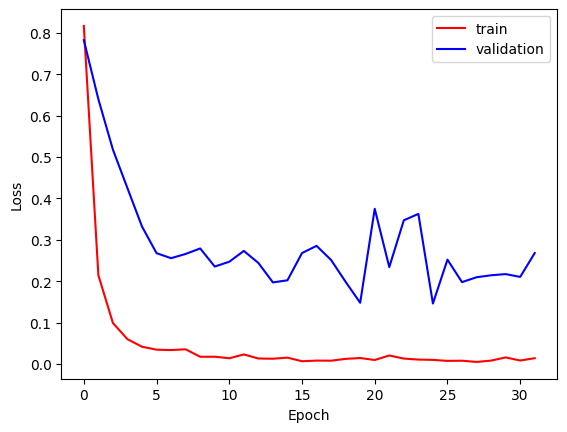

In [73]:
plt.plot(history_batch_relu.history['loss'],color='red',label='train')
plt.plot(history_batch_relu.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_true = test_generator.classes

y_pred_probs = model_densenet_relu_batch.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Classification Report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
y_true = train_generator.classes

y_pred_probs = model_densenet_relu_batch.predict(train_generator, steps=train_generator.samples // train_generator.batch_size + 1)

y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Classification Report
class_names = list(train_generator.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


In [74]:
summary_df

,Model,Parameters,Train Accuracy,Train Loss,Train Precision,Train Recall,Test Accuracy,Test Loss,Test Precision,Test Recall
0,Model1: Basic CNN,"Conv2D stack, LeakyReLU",1.0000,0.0473,0.3111,0.3111,0.9242,0.2532,0.9292,0.9167
1,VGG19,"VGG19, ReLU",1.0000,0.0000,0.3285,0.3285,0.9697,0.3604,0.9675,0.9705
2,VGG19 - Fine Tuning,"VGG19,ReLU,Dropout",1.0000,0.0019,0.3758,0.3758,0.9394,0.2041,0.9360,0.9333
3,DenseNet - Image augumentation,"DenseNet,GlorotNormal",1.0000,0.0028,0.3539,0.3539,0.9545,0.1479,0.9516,0.9538
4,DenseNet-Image augumentation,"DenseNet,ReLU,batchNormalization",1.0000,0.0089,0.3316,0.3316,0.8636,0.2947,0.8825,0.8615
5,DenseNet-Image augumentation,"DenseNet,ReLU,batchNormalization,Dropout",1.0000,0.0193,0.3101,0.3101,0.9091,0.2448,0.9231,0.9038


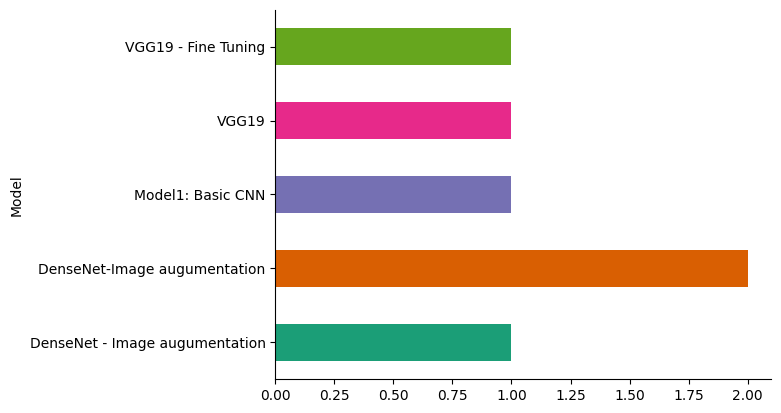

In [76]:
# @title Model

from matplotlib import pyplot as plt
import seaborn as sns
summary_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [75]:
summary_df.to_csv('model_summary.csv', index=False)

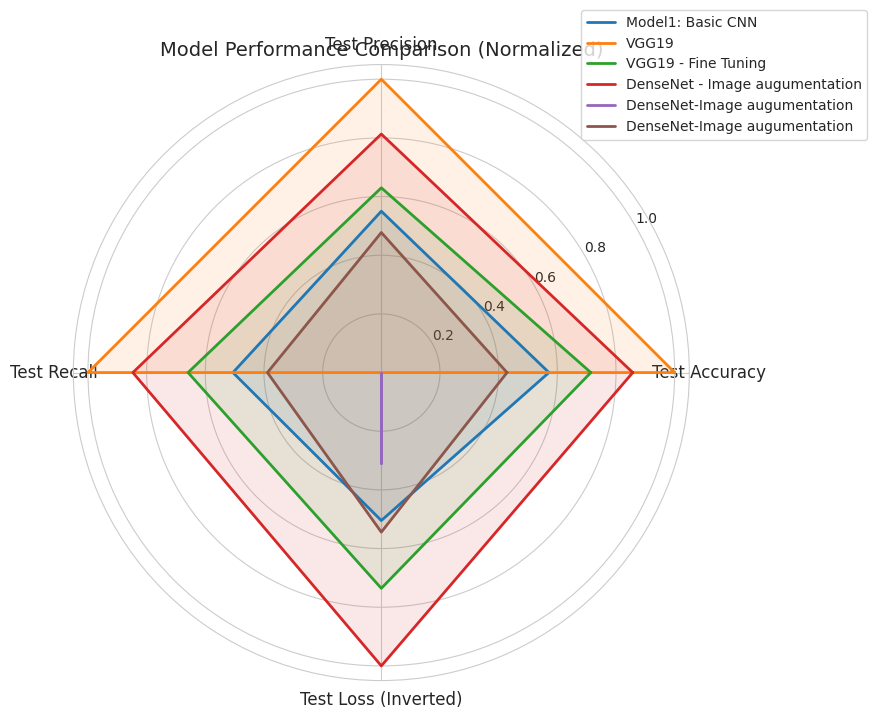

Radar chart saved as model_performance_radar_chart.png


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# Set seaborn style
sns.set_style("whitegrid")


# Create DataFrame
df = summary_df

# Normalize Test Loss so higher is better
max_loss = df["Test Loss"].max()
df["Normalized Loss"] = max_loss - df["Test Loss"]

# Rename for clarity
df = df.rename(columns={"Normalized Loss": "Test Loss (Inverted)"})

# Prepare data for radar chart
metrics = ["Test Accuracy", "Test Precision", "Test Recall", "Test Loss (Inverted)"]

# Normalize all metrics to [0, 1] range
df_normalized = df.copy()
for metric in metrics:
    min_val = df[metric].min()
    max_val = df[metric].max()
    df_normalized[metric] = (df[metric] - min_val) / (max_val - min_val)

# Radar chart setup
labels = metrics
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df_normalized.iterrows():
    values = row[labels].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=2, label=row["Model"])
    ax.fill(angles, values, alpha=0.1)

# Add labels
plt.xticks(angles[:-1], labels, fontsize=12)
ax.set_rlabel_position(30)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10)
plt.title("Model Performance Comparison (Normalized)", fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()
# Save plot
output_path = "model_performance_radar_chart.png"
plt.savefig(output_path, bbox_inches='tight')
plt.close()

print("Radar chart saved as model_performance_radar_chart.png")


# Observation
Best Model Based on Test Performance
Model 1: VGG19
Test Accuracy: 0.9697 (highest)

Test Precision: 0.9675 (highest)

Test Recall: 0.9705 (highest)

Test Loss: 0.3604 (not the lowest, but acceptable)

this model generalizes best to unseen data. Its precision and recall are both above 96%, which means it's not just accurate—it's consistent in identifying both failures and non-failures.

In [90]:
from keras_tuner import RandomSearch
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def build_model(hp):
    tf.keras.backend.clear_session()  # Clear memory between trials
    model = tf.keras.Sequential()

    # First Conv Layer
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation=None,
        input_shape=(224, 224, 3)
    ))

    if hp.Boolean('batch_norm_1'):
        model.add(tf.keras.layers.BatchNormalization())

    activation_1 = hp.Choice('activation_1', ['relu', 'elu'])
    model.add(tf.keras.layers.Activation(activation_1))

    model.add(tf.keras.layers.Dropout(hp.Float('dropout_1', 0.2, 0.4, step=0.1)))

    # Second Conv Layer
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation=None
    ))

    if hp.Boolean('batch_norm_2'):
        model.add(tf.keras.layers.BatchNormalization())

    activation_2 = hp.Choice('activation_2', ['relu', 'elu'])
    model.add(tf.keras.layers.Activation(activation_2))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_2', 0.2, 0.4, step=0.1)))

    model.add(tf.keras.layers.Flatten())

    # Dense Layer
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation=hp.Choice('dense_activation', ['relu', 'elu'])
    ))

    model.add(tf.keras.layers.Dropout(hp.Float('dropout_dense', 0.2, 0.4, step=0.1)))

    # Output Layer
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    # Optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Tuner setup
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Reduced for memory safety
    executions_per_trial=1,
    directory='tuning_results',
    project_name='chest_xray_tuning'
)

# Make sure your generators use a smaller batch size (e.g., 8 or 16)
tuner.search(train_generator, validation_data=val_generator, epochs=30)


Physical devices cannot be modified after being initialized
Reloading Tuner from tuning_results/chest_xray_tuning/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |64                |filters_1
3                 |3                 |kernel_size_1
True              |False             |batch_norm_1
relu              |leaky_relu        |activation_1
0.3               |0.2               |dropout_1
96                |256               |filters_2
3                 |5                 |kernel_size_2
True              |True              |batch_norm_2
relu              |elu               |activation_2
0.4               |0.4               |dropout_2
512               |448               |dense_units
elu               |relu              |dense_activation
0.2               |0.2               |dropout_dense
rmsprop           |adam              |optimizer
0.0077119         |0.0016101         |learning_rate



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_b

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 155, in _build_hypermodel
    model = self.hypermodel.build(hp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3945322783.py", line 54, in build_model
    model.add(tf.keras.layers.Dense(
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 122, in add
    self._maybe_rebuild()
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 149, in _maybe_rebuild
    self.build(input_shape)
  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 232, in build_wrapper
    original_build_method(*args, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 195, in build
    x = layer(x)
        ^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/random.py", line 34, in uniform
    return tf.random.stateless_uniform(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tensorflow.python.framework.errors_impl.ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 


In [91]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=20,
#     executions_per_trial=1,
#     directory='tuning_results',
#     project_name='chest_xray_tuning'
# )

# tuner.search(train_generator, validation_data=val_generator, epochs=50)


In [81]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_params = {param: best_hps.get(param) for param in best_hps.values.keys()}

import json
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)


In [93]:
# Save the best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_transfer.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history_transfer = model_transfer.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint_callback] # Add checkpoint_callback here
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9971 - loss: 0.0229
Epoch 1: val_loss improved from inf to 0.31025, saving model to best_model_transfer.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 874ms/step - accuracy: 0.9962 - loss: 0.0263 - val_accuracy: 0.9200 - val_loss: 0.3102
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9883 - loss: 0.0495
Epoch 2: val_loss improved from 0.31025 to 0.21892, saving model to best_model_transfer.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.9873 - loss: 0.0552 - val_accuracy: 0.9000 - val_loss: 0.2189
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9733 - loss: 0.1411
Epoch 3: val_loss improved from 0.21892 to 0.13592, saving model to best_model_transfer.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 662ms/step - accuracy: 0.9717 - loss: 0.1461 - val_accuracy: 0.9400 - val_loss: 0.1359
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9742 - loss: 0.0547
Epoch 4: val_loss did not improve from 0.13592
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.9737 - loss: 0.0551 - val_accuracy: 0.9200 - val_loss: 0.3392
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9904 - loss: 0.0820
Epoch 5: val_loss did not improve from 0.13592
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.9891 - loss: 0.0905 - val_accuracy: 0.9000 - val_loss: 0.2114
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9761 - loss: 0.1248
Epoch 6: val_loss did not improve from 0.13592
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 694ms/step - accuracy: 0.9760 - loss: 0.1217 - val_accuracy: 0.9200 - val_loss: 0.2329
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9985 - loss: 0.0064
Epoch 7: val_loss did not improve from 0.13592
7/7 ━━━━━━━━

In [94]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00


In [95]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

# Load your trained model
model = tf.keras.models.load_model('best_model_transfer.h5')  # Replace with your model path

# Define class names
class_names = ['Normal', 'Pneumonia', 'COVID-19']  # Adjust based on your model

# Image preprocessing
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to model input
    img_array = np.array(img) / 255.0  # Normalize
    if img_array.ndim == 2:  # Grayscale to RGB
        img_array = np.stack((img_array,) * 3, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Streamlit UI
st.title("🩻 Chest X-ray Diagnosis")
st.write("Upload a chest X-ray image to predict the condition.")

uploaded_file = st.file_uploader("Choose an X-ray image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded X-ray", use_column_width=True)

    st.write("Processing...")
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    st.success(f"Prediction: **{predicted_class}**")
    st.info(f"Confidence: {confidence:.2f}")


2025-08-16 14:16:51.741 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 14:16:51.905 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-16 14:16:51.908 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 14:16:51.909 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 14:16:51.910 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 14:16:51.910 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 14:16:51.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 14:16:51.915 Thread 'MainThread': mi

In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model('my_model.h5')